## 1. Import and observe dataset

We all love watching movies! There are some movies we like, some we don't. Most people have a preference for movies of a similar genre. Some of us love watching action movies, while some of us like watching horror. Some of us like watching movies that have ninjas in them, while some of us like watching superheroes.

Movies within a genre often share common base parameters. For example, both movies, Toy stories and The lion king, are movies for kids and they indeed share many similarities. We could conclude that both of these fall into the same genre of movies based on intuition, but that's no fun in a data science context. In this project, we will quantify the similarity of movies based on their plot summaries available on IMDb, then separate them into groups, also known as clusters. 

Let's start by importing the dataset and observing the data we collected.

In [1]:
# Import modules
import numpy as np
import pandas as pd
import nltk

# Set seed for reproducibility
np.random.seed(5)

movies_df = pd.read_csv('../dataset/movie_info.csv')

# show the top 10 rows
movies_df.head(10)

,title,release year,genre,key words,plot,run time /min,number of votes,rating
0,Sharknado,2013,Action|Adventure|Comedy|Horror|Sci-Fi|Thriller,school-bus|chainsaw|psychotronic-film|hurrican...,"When a freak hurricane swamps Los Angeles, nat...",86,44265,3.3
1,The Normal Heart,2014,Drama|History|Romance,gay|gay-men's-health-crisis|hiv|aids-epidemic|...,A gay activist attempts to raise H.I.V. and A....,132,31793,7.9
2,The Sunset Limited,2011,Drama,minimal-cast|dialogue-between-two-characters|s...,"Through a chance encounter, two men of opposin...",91,26733,7.4
3,Temple Grandin,2010,Biography|Drama,cattle|animal-husbandry|livestock|autism|feedi...,"A biopic of Temple Grandin, an autistic woman ...",107,25551,8.3
4,You Don't Know Jack,2010,Biography|Drama,suicide|assisted-suicide|moral-dilemma|moralit...,A look at the life and work of doctor-assisted...,134,25404,7.6
5,Game Change,2012,Biography|Drama|History,american-politics|cell-phone|down-syndrome|pre...,Governor Sarah Palin of Alaska becomes Senator...,118,20092,7.4
6,Princess Protection Program,2009,Comedy|Drama|Family,princess|dictator|teenager|protection|louisian...,A princess whose country has been invaded goes...,90,20083,5.6
7,Mean Girls 2,2011,Comedy,sexiness|dream-girl|short-skirt|miniskirt|teen...,The Plastics are back in the long-awaited foll...,96,19579,4.1
8,The Wizard of Lies,2017,Biography|Crime|Drama,financial-fraud|financier|ponzi-scheme|fraudst...,"The fall of Bernie Madoff, whose Ponzi scheme ...",133,19471,6.8
9,Sharknado 2: The Second One,2014,Action|Adventure|Comedy|Horror|Sci-Fi|Thriller,second-part|john-f.-kennedy-international-airp...,Fin and April are on their way to New York Cit...,95,17067,4.0


## 2. Tokenization and Stemming

**Tokenization** is the process  by which we break down articles into individual sentences or words, as needed. Besides the tokenization method provided by NLTK, we might have to perform additional filtration to remove tokens which are entirely numeric values or punctuation.

**Stemming** is the process by which we bring down a word from its different forms to the root word. This helps us establish meaning to different forms of the same words without having to deal with each form separately. 

First, let us perform tokenization on a small extract from Mean Girls 2.

In [2]:
# Tokenize a paragraph into sentences and store in sent_tokenized
sent_tokenized = [sent for sent in nltk.sent_tokenize("""
                        The Plastics are back in the long-awaited follow-up to the smash hit Mean Girls - and now the clique is more fashionable, funny, and ferocious than ever.
                        """)]

# Word Tokenize first sentence from sent_tokenized, save as words_tokenized
words_tokenized = [word for word in nltk.word_tokenize(sent_tokenized[0])]

# Remove tokens that do not contain any letters from words_tokenized
import re

filtered = [word for word in words_tokenized if re.search('[a-zA-Z]', word)]

# Display filtered words to observe words after tokenization
filtered

['The',
 'Plastics',
 'are',
 'back',
 'in',
 'the',
 'long-awaited',
 'follow-up',
 'to',
 'the',
 'smash',
 'hit',
 'Mean',
 'Girls',
 'and',
 'now',
 'the',
 'clique',
 'is',
 'more',
 'fashionable',
 'funny',
 'and',
 'ferocious',
 'than',
 'ever']

There are different algorithms available for stemming such as the Porter Stemmer, Snowball Stemmer, and such. We shall use the Snowball Stemmer.

In [3]:
# Import the SnowballStemmer to perform stemming
from nltk.stem.snowball import SnowballStemmer

# Create an English language SnowballStemmer object
stemmer = SnowballStemmer("english")

# Print filtered to observe words without stemming
print("Without stemming: ", filtered)

# Stem the words from filtered and store in stemmed_words
stemmed_words = [stemmer.stem(word) for word in filtered]

# Print the stemmed_words to observe words after stemming
print("After stemming:   ", stemmed_words)

Without stemming:  ['The', 'Plastics', 'are', 'back', 'in', 'the', 'long-awaited', 'follow-up', 'to', 'the', 'smash', 'hit', 'Mean', 'Girls', 'and', 'now', 'the', 'clique', 'is', 'more', 'fashionable', 'funny', 'and', 'ferocious', 'than', 'ever']
After stemming:    ['the', 'plastic', 'are', 'back', 'in', 'the', 'long-await', 'follow-up', 'to', 'the', 'smash', 'hit', 'mean', 'girl', 'and', 'now', 'the', 'cliqu', 'is', 'more', 'fashion', 'funni', 'and', 'feroci', 'than', 'ever']


We are now able to tokenize and stem sentences. But we may have to use the two functions repeatedly one after the other to handle a large amount of data, hence we can think of wrapping them in a function and passing the text to be tokenized and stemmed as the function argument. Then we can pass the new wrapping function, which shall perform both tokenizing and stemming instead of just tokenizing, as the tokenizer argument while creating the TF-IDF vector of the text.

First, let us define a function to perform both stemming and tokenization

In [4]:
def tokenize_and_stem(text):
    
    # Tokenize by sentence, then by word
    tokens = nltk.word_tokenize(text)
    
    
    # Filter out raw tokens to remove noise
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
    
    # Stem the filtered_tokens
    stems = [stemmer.stem(word) for word in filtered_tokens]
    
    return stems

Apply the function on the plot of Mean Girls 2 for example:

In [5]:
words_stemmed = tokenize_and_stem("The Plastics are back in the long-awaited follow-up to the smash hit Mean Girls - and now the clique is more fashionable, funny, and ferocious than ever.")
print(words_stemmed)

['the', 'plastic', 'are', 'back', 'in', 'the', 'long-await', 'follow-up', 'to', 'the', 'smash', 'hit', 'mean', 'girl', 'and', 'now', 'the', 'cliqu', 'is', 'more', 'fashion', 'funni', 'and', 'feroci', 'than', 'ever']


It gave us the same result, which means that the function is good to go.

## 3. Create TfidfVectorizer

Computers do not understand text. These are machines only capable of understanding numbers and performing numerical computation. Hence, we must convert our textual plot summaries to numbers for the computer to be able to extract meaning from them. One simple method of doing this would be to count all the occurrences of each word in the entire vocabulary and return the counts in a vector. 

Term Frequency-Inverse Document Frequency (TF-IDF) is one method which overcomes the shortcomings of CountVectorizer. The Term Frequency of a word is the measure of how often it appears in a document, while the Inverse Document Frequency is the parameter which reduces the importance of a word if it frequently appears in several documents.

In simplest terms, TF-IDF recognizes words which are unique and important to any given document. Let's create one for our purposes.

In [6]:
# Import TfidfVectorizer to create TF-IDF vectors
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate TfidfVectorizer object with stopwords and tokenizer
# parameters for efficient processing of text
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, max_features=200000,
                                 min_df=2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem,
                                 ngram_range=(1,3))

## 4. Fit transform TfidfVectorizer

Once we create a TF-IDF Vectorizer, the next step is to fit the text to it and then transform the text to produce the corresponding numeric form of the data which the computer will be able to understand and derive meaning from. To do this, we use the fit_transform() method of the TfidfVectorizer object. 

If we observe the TfidfVectorizer object we created, we come across a parameter stopwords. 'stopwords' are those words in a given text which do not contribute considerably towards the meaning of the sentence and are generally grammatical filler words. 
   
On setting the stopwords to 'english', we direct the vectorizer to drop all stopwords from a pre-defined list of English language stopwords present in the nltk module. Another parameter, ngram_range, defines the length of the ngrams to be formed while vectorizing the text.

In [7]:
# Fit and transform the tfidf_vectorizer with the "plot" of each movie
# to create a vector representation of the plot summaries
tfidf_matrix = tfidf_vectorizer.fit_transform([x for x in movies_df["plot"]])
print(tfidf_matrix.shape)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(3167, 11538)


## 5. K-means clustering

To determine how closely one movie is related to the other by the help of unsupervised learning, we can use clustering techniques. Clustering is the method of grouping together a number of items such that they exhibit similar properties. According to the measure of similarity desired, a given sample of items can have one or more clusters. 

1. look for the elbow to determine the optimal number of clusters
2. check the number of samples per group to confirm we have balanced samples accross k-means groups

**1. look for the elbow to determine the optimal number of clusters**

Mini Batch K-means algorithm‘s main idea is to use small random batches of data of a fixed size, so they can be stored in memory. Each iteration of a new random sample from the dataset is obtained and used to update the clusters and this is repeated until convergence. Each mini batch updates the clusters using a convex combination of the values of the prototypes and the data, applying a learning rate that decreases with the number of iterations. This learning rate is the inverse of the number of data assigned to a cluster during the process. As the number of iterations increases, the effect of new data is reduced, so convergence can be detected when no changes in the clusters occur in several consecutive iterations.

Probably the most well known method, the elbow method, in which the sum of squares at each number of clusters is calculated and graphed, and the user looks for a change of slope from steep to shallow (an elbow) to determine the optimal number of clusters. This method is inexact, but still potentially helpful.

In [9]:
from sklearn.cluster import MiniBatchKMeans

# init potential n_clusters
n_clusters_list = list(range(1, 60, 1))
# init scores
scores = []
# init models for cache
kms = {}
for n_clusters in n_clusters_list:
    km = MiniBatchKMeans(
        n_clusters=n_clusters,
        random_state=99
    ).fit(tfidf_matrix)
    # save models
    kms.update({n_clusters: km})
    # save score
    scores.append(-1 * km.score(tfidf_matrix))

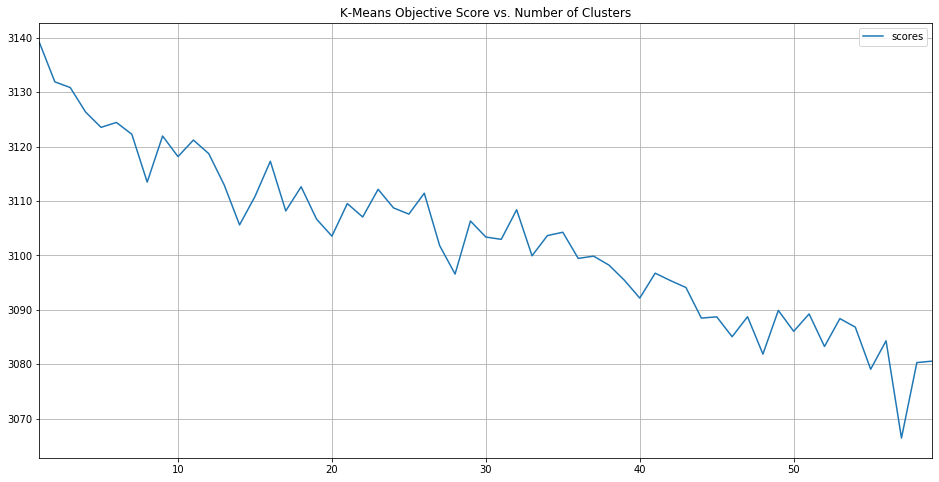

In [11]:
# look for elbow to determine optimal number of clusters
pd.DataFrame({'scores': scores}, index=n_clusters_list).plot(
    figsize=(16, 8),
    title='K-Means Objective Score vs. Number of Clusters',
    grid=True
)

In [12]:
# pick optimal K-means Model
n = 12
km = kms[n]
clusters = km.labels_.tolist()

# Fit the k-means object with tfidf_matrix
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

# create DataFrame df_clusters for clustering analysis
data_clusters = {
    'title': movies_df.title.values,
    'plot': movies_df['plot'].values,
    'run time': movies_df['run time /min'].values,
    'votes': movies_df['number of votes'].values,
    'rating':movies_df.rating.values,
    'cluster': clusters
}
df_clusters = pd.DataFrame(
    data_clusters,
    index=[clusters],
    columns=['title','plot','run time', 'votes','rating', 'cluster']
)

df_clusters.head(5)

,title,plot,run time,votes,rating,cluster
5,Sharknado,"When a freak hurricane swamps Los Angeles, nat...",86,44265,3.3,5
5,The Normal Heart,A gay activist attempts to raise H.I.V. and A....,132,31793,7.9,5
5,The Sunset Limited,"Through a chance encounter, two men of opposin...",91,26733,7.4,5
5,Temple Grandin,"A biopic of Temple Grandin, an autistic woman ...",107,25551,8.3,5
9,You Don't Know Jack,A look at the life and work of doctor-assisted...,134,25404,7.6,9


**2. check the number of samples per group to confirm we have balanced samples accross k-means groups**

In [13]:
print("Number of movies included in each cluster:")
df_clusters['cluster'].value_counts().to_frame()

Number of movies included in each cluster:


,cluster
5,1740
9,1176
2,77
6,66
10,38
1,18
3,13
11,11
0,9
4,7


## 6. Calculate Movie Simialrity

**Use cosine similarity to calculate similarity of movie plots**

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

# get similarity matrix using tfidf matrix
sim_matrix = cosine_similarity(tfidf_matrix)

In [15]:
def movie_recommender_cosine_similarity(movie_title, K):
    if (len(movies_df[movies_df['title']==movie_title])==0):
        print("Sorry, we don't have this movie in our database. But we will take it into consideration in the future, thank you!")
    else:
        movie_idx = movies_df[movies_df['title'] == movie_title].index[0]
        return movies_df.loc[np.argsort(sim_matrix[movie_idx])[::-1][:K]]

Again, let's use 'Mean Girls 2' as an example:

In [16]:
movie_title = str(input("which movie you want to search? "))
K = int(input("How many most similarity movies you want to display? "))

movie_recommender_cosine_similarity(movie_title, K)

which movie you want to search? Mean Girls 2
How many most similarity movies you want to display? 10


,title,release year,genre,key words,plot,run time /min,number of votes,rating
7,Mean Girls 2,2011,Comedy,sexiness|dream-girl|short-skirt|miniskirt|teen...,The Plastics are back in the long-awaited foll...,96,19579,4.1
489,Certain Prey,2011,Action|Crime|Thriller,off-screen-rape|cell-phone-photograph|cell-pho...,"Minneapolis Deputy Police Chief, Lucas Davenpo...",85,1129,5.4
73,Mega Piranha,2010,Action|Adventure|Comedy|Horror|Sci-Fi|Thriller,psychotronic-film|piranha|science|amazon|tople...,A mutant strain of giant ferocious piranha esc...,92,5200,2.4
183,Dinoshark,2010,Action|Adventure|Comedy|Fantasy|Horror|Sci-Fi|...,psychotronic-film|dinoshark|creature|arctic|gl...,A baby dinoshark evolves into a ferocious pred...,92,2443,3.1
1402,McQueen and I,2011,Documentary|Biography,fashion-designer|fashion|catwalk|hawk|fashion-...,Profile of British fashion designer Alexander ...,71,202,7.4
1868,Sexy Assassins,2012,Romance,nudity|male-nudity|female-nudity|softcore|sex,A gorgeous hit woman pulls the trigger on pass...,79,81,6.2
117,Donald Trump's The Art of the Deal: The Movie,2016,Comedy,nazi-salute|donald-trump-character|looking-at-...,Funny or Die presents a satirical rendition of...,50,3583,5.9
439,Beyond Sherwood Forest,2009,Action|Adventure|Fantasy,sword-and-sorcery|stealing-from-the-rich-givin...,England 1174: King Richard is away fighting th...,93,1253,4.5
54,Teen Spirit,2011,Comedy|Drama|Fantasy,prom|ghost-girl|female-ghost|female-protagonis...,"The story is about Amber, a mean popular girl ...",82,6691,5.5
2734,"Glamour Models, Mum and Me",2010,Documentary,glamour-models|female-nudity|nudity|plastic-su...,The story of an extraordinary mother-daughter ...,60,21,6.6


What if we input some movie that doesn't exist in the dataset? say input "I am not a movie"

In [17]:
movie_title = str(input("which movie you want to search? "))
K = int(input("How many most similarity movies you want to display? "))

movie_recommender_cosine_similarity(movie_title, K)

which movie you want to search? I am not a movie
How many most similarity movies you want to display? 10
Sorry, we don't have this movie in our database. But we will take it into consideration in the future, thank you!
